In [ ]:
using PauliPropagation
using Plots
using ReverseDiff: GradientTape, gradient!, compile, gradient
#include("anticommutator.jl") # eff calc of vscore


# Test of the V-Score calculation for the TFIM

### System setup and GS search
- 10 qubits, chain, obc
- QAOA ansatz is only suitable for the FM phase, but requires only few parameters
- setup taken from CDR paper (Czarnik et al.)
- not useful for the Hamiltonians of the VB paper, but includes a vscore calculation

In [2]:
nq = 10
nl = 6; # expressivity of qaoa ansatz

In [3]:
function tfimqaoacircuit(nqubits::Integer, nlayers::Integer; topology=nothing)
    circuit::Vector{Gate} = []

    if isnothing(topology)
        topology = bricklayertopology(nqubits;periodic=false) #chain with obc
    end

    for i in 1:nlayers
        rzzlayer!(circuit, topology)
        for qubit in 1:nqubits
            push!(circuit, CliffordGate(:S, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2)) # Fig 10: P=R_X(π/2)
            push!(circuit, PauliRotation(:Z, qubit)) # only this is parametrized
            push!(circuit, PauliRotation(:X, qubit, π/2))
            push!(circuit, CliffordGate(:S, qubit))

        end
    end
    return circuit, topology
end

tfimqaoacircuit (generic function with 1 method)

In [4]:
function repartition_function_QAOA(nqubits, nlayers) #qaoa repartition function
    repartition = Vector{Vector{Int}}()
    idx = 1
    for i in 1:nlayers
            push!(repartition, collect(idx:idx + (nqubits - 2)))  # First nqubits-1 indices
            idx += (nqubits - 1)
            push!(repartition, collect(idx:idx + nqubits - 1))  # Next nqubits indices
            idx += nqubits
    end
    return repartition
end

repartition_function_QAOA (generic function with 1 method)

In [ ]:
function constrain_params(thetas, repartition) #corresponding to qaoa ansatz
    for r in repartition
        for q in r
            thetas[q] = thetas[r[1]]
        end
    end
    return thetas
end

constrain_params (generic function with 1 method)

In [ ]:
function fulllossfunction(thetas, circuit, nq; J=1.0, G=1.0, topology=nothing, max_freq = Inf, max_weight = Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    # differentiation libraries use custom types to trace through the computation
    # we need to make all of our objects typed like that so that nothing breaks
    CoeffType = eltype(thetas)

    # define H again 
    H = PauliSum(CoeffType, nq)
    for qind in 1:nq
        add!(H, :X, qind, CoeffType(J))
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), CoeffType(G))
    end

    # wrap the coefficients into PauliFreqTracker so that we can use `max_freq` truncation.
    # usually this happens automatically but the in-place propagate!() function does not allow that.
    wrapped_H = wrapcoefficients(H, PauliFreqTracker)

    # we also need to run the in-place version with `!`, because by default we copy the Pauli sum
    output_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
    return overlapwithplus(output_H)
end

fulllossfunction (generic function with 1 method)

In [ ]:
function gd(thetas_init,closed_lossfunction, nqubits, repartition; eta=0.01, steps=100)
    

    # some inputs and work buffer to play around with
    grad_array_compiled = similar(thetas_init);

    # pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements
    
    simulation_tape = GradientTape(closed_lossfunction, thetas_init)
    compiled_simulation_tape = compile(simulation_tape)

    opt_energy_gd = []
    thetas = thetas_init
    for i in 1:steps 
        gradient!(grad_array_compiled, simulation_tape, thetas)
        thetas .-= eta * grad_array_compiled
        constrain_params(thetas, repartition)
        opt_energy_gd = push!(opt_energy_gd, closed_lossfunction(thetas)/nqubits)
    end

    return thetas, opt_energy_gd
end

gd (generic function with 1 method)

In [ ]:
## ADAM implementation

# Build a gather index that enforces tying without mutation
# For each parameter j, gather[j] = representative index of its tie group
function build_tie_gather(repartition::Vector{Vector{Int}}, nparams::Int)
    gather = collect(1:nparams)                 # default: each points to itself
    for r in repartition
        rep = r[1]
        for j in r
            gather[j] = rep
        end
    end
    return gather
end

# Adam optimizer (same signature as `gd`)
function adam(thetas_init, closed_lossfunction, nqubits, repartition; eta=0.02, steps=100)
    nparams = length(thetas_init)
    gather = build_tie_gather(repartition, nparams)

    # Tie parameters via indexing (no setindex! anywhere)
    loss_tied = let f = closed_lossfunction, gath = gather
        θ -> f(θ[gath])                          # θ[gath] enforces tying
    end

    # ReverseDiff tape on the tied loss (same as GD system)
    tape = GradientTape(loss_tied, thetas_init)
    compiled_tape = compile(tape)

    # Buffers & Adam state
    grad = similar(thetas_init)
    thetas = copy(thetas_init)
    opt_energy = Vector{Float64}(undef, 0)

    m = zero(thetas); v = zero(thetas)
    β1, β2, ϵ = 0.9, 0.999, 1e-8

    for t in 1:steps
        gradient!(grad, tape, thetas)

        # Adam update
        m .= β1 .* m .+ (1 - β1) .* grad
        v .= β2 .* v .+ (1 - β2) .* (grad .^ 2)
        mhat = m ./ (1 - β1^t)
        vhat = v ./ (1 - β2^t)
        thetas .-= eta .* mhat ./ (sqrt.(vhat) .+ ϵ)

        # Log E/Q using the tied view
        push!(opt_energy, loss_tied(thetas) / nqubits)
    end
    return thetas[gather], opt_energy
end


adam (generic function with 1 method)

In [9]:
function target_optimization(nqubits, nlayers,repartition,circuit; J=1.0, G=1.0, max_freq=Inf, max_weight=Inf, verbose = false)

    thetas_init = rand((2*nqubits-1)*nlayers) 
    println(length(thetas_init))
    thetas_init = constrain_params(thetas_init, repartition)
    closed_lossfunction = let const_nqubits = nqubits, const_nlayers = nlayers, const_J=J, const_G=G, const_max_freq=max_freq, const_max_weight=max_weight
        # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
        # See also "closures"
        theta -> fulllossfunction(theta, circuit, nqubits; J=const_J, G=const_G, max_freq=const_max_freq, max_weight=const_max_weight)
    end
    opt_thetas, opt_energy_gd = adam(thetas_init,closed_lossfunction,nqubits,repartition)
    if verbose
        println("Optimized thetas: ", opt_thetas)
        println("Optimized energy per qubit: ", opt_energy_gd[end])

        plot(opt_energy_gd)
        display(plot!(title = "Energy optimisation", xlabel = "runs", ylabel = "E/Q"))
    end

    return opt_thetas, opt_energy_gd
end

target_optimization (generic function with 1 method)

In [10]:
function fulllossfunction_H2(thetas, circuit, nq; J=1.0, G=1.0, topology=nothing, max_freq = Inf, max_weight = Inf)
    if isnothing(topology)
        topology = bricklayertopology(nq;periodic=false) #chain with obc
    end

    # differentiation libraries use custom types to trace through the computation
    # we need to make all of our objects typed like that so that nothing breaks
    CoeffType = eltype(thetas)

    # define H again 
    H = PauliSum(CoeffType, nq)
    for qind in 1:nq
        add!(H, :X, qind, CoeffType(J))
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), CoeffType(G))
    end
    H2 = H*H # brute force for now (factor lin. worse than anticomm method)
    # wrapp the coefficients into PauliFreqTracker so that we can use `max_freq` truncation.
    # usually this happens automatically but the in-place propagate!() function does not allow that.

    wrapped_H = wrapcoefficients(H2, PauliFreqTracker)

    # be also need to run the in-place version with `!`, because by default we copy the Pauli sum
    output_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
    return overlapwithplus(output_H)
end

fulllossfunction_H2 (generic function with 1 method)

In [11]:
repartition = repartition_function_QAOA(nq, nl)

12-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9]
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
 [20, 21, 22, 23, 24, 25, 26, 27, 28]
 [29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
 [39, 40, 41, 42, 43, 44, 45, 46, 47]
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
 [58, 59, 60, 61, 62, 63, 64, 65, 66]
 [67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
 [77, 78, 79, 80, 81, 82, 83, 84, 85]
 [86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
 [96, 97, 98, 99, 100, 101, 102, 103, 104]
 [105, 106, 107, 108, 109, 110, 111, 112, 113, 114]

In [12]:
circuit = tfimqaoacircuit(nq, nl)[1]

354-element Vector{Gate}:
 PauliRotation([:Z, :Z], [1, 2])
 PauliRotation([:Z, :Z], [3, 4])
 PauliRotation([:Z, :Z], [5, 6])
 PauliRotation([:Z, :Z], [7, 8])
 PauliRotation([:Z, :Z], [9, 10])
 PauliRotation([:Z, :Z], [2, 3])
 PauliRotation([:Z, :Z], [4, 5])
 PauliRotation([:Z, :Z], [6, 7])
 PauliRotation([:Z, :Z], [8, 9])
 CliffordGate(:S, [1])
 ⋮
 FrozenGate(PauliRotation([:X], [9]), parameter = 1.57)
 PauliRotation([:Z], [9])
 FrozenGate(PauliRotation([:X], [9]), parameter = 1.57)
 CliffordGate(:S, [9])
 CliffordGate(:S, [10])
 FrozenGate(PauliRotation([:X], [10]), parameter = 1.57)
 PauliRotation([:Z], [10])
 FrozenGate(PauliRotation([:X], [10]), parameter = 1.57)
 CliffordGate(:S, [10])

# V-Score calculation for QAOA with CDR-paper parameters
$$
 H = -g \sum_{<i,j>}Z_iZ_j -\sum_i X_i .
 $$
 
as seen in the CDR paper. For Variational Benchmark TFIM, set g=-1 and change sign of X term.
$$
 \mathrm{v-score}= \frac{N \mathrm{Var} E}{(E-E_\infty)^2}
 $$

 $$
 \mathrm{Var} E = <H^2>-<H>^2
$$ 

114
Optimized thetas: [0.18170789746942248, 0.18170789746942248, 0.18170789746942248, 0.18170789746942248, 0.18170789746942248, 0.18170789746942248, 0.18170789746942248, 0.18170789746942248, 0.18170789746942248, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.8033153929197203, 0.04345966530474238, 0.04345966530474238, 0.04345966530474238, 0.04345966530474238, 0.04345966530474238, 0.04345966530474238, 0.04345966530474238, 0.04345966530474238, 0.04345966530474238, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.7406146564986413, 0.43635364149117567, 0.43635364149117567, 0.43635364149117567, 0.43635364149117567, 0.43635364149117567, 0.43635364149117567, 0.43635364149117567, 0.43635364149117567, 0.43635364149117567, 0.36111007

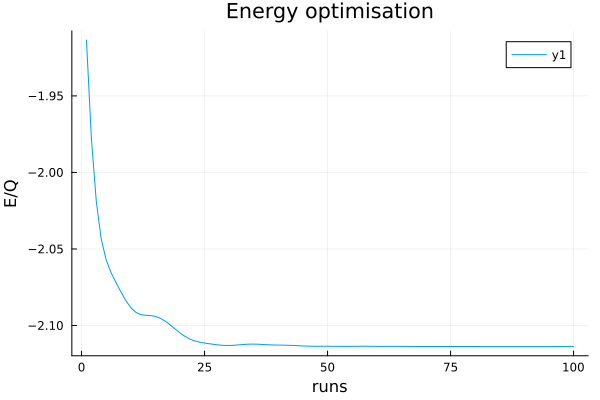

In [13]:
J_CDR = -2.0
G_CDR = -1.0
opt_thetas_target, opt_energy_gd = target_optimization(nq,nl,repartition, circuit;J=J_CDR,G=G_CDR, max_freq=Inf, max_weight=Inf, verbose = true);

In [14]:
sq_exp_energy = fulllossfunction(opt_thetas_target, circuit, nq;J=J_CDR,G=G_CDR)^2

446.80439554128463

In [15]:
fulllossfunction_H2(opt_thetas_target, circuit, nq; J=J_CDR, G=G_CDR)

446.81729416598125 + 0.0im

In [16]:
varE = fulllossfunction_H2(opt_thetas_target, circuit, nq; J=J_CDR, G=G_CDR) - sq_exp_energy

0.012898624696617844 + 0.0im

In [17]:
E_inf = 0 # energy shift of Hamiltonian (vscore invariant under shift)
vscore = varE*nq/(sq_exp_energy-E_inf)^2

6.461130794350512e-7 + 0.0im